1. Setup and Imports
We imported necessary libraries and defined the device configuration for training. Apple silicon processor M1. 

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from PIL import Image
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Check for device: use MPS if available, otherwise use CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


In [2]:
import wandb
import os

# Set the notebook name
os.environ["WANDB_NOTEBOOK_NAME"] = "INM705_Deep_Learning_for_Image_Analysis_EM_ML.ipynb"


# Login with the API KEY
wandb.login(key="9ce954fd827fd8d839648cb3708ff788ad51bafa")

wandb: Currently logged in as: enxo7899 (em-city). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/enxom/.netrc


True

2. Data Preparation
This snippet involves loading the data, defining image transformations, and preparing DataLoader objects for training, validation, and testing datasets.

In [3]:
import os
import glob
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from PIL import Image

def is_valid_file(file_path):
    # List of valid image extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp']
    # Check if file ends with a valid extension
    return any(file_path.endswith(ext) for ext in valid_extensions)

def collect_data(directory):
    # Initialize lists to store data and labels
    data = []
    labels = []
    # Map each class to an index
    class_to_idx = {cls: idx for idx, cls in enumerate(os.listdir(directory)) if os.path.isdir(os.path.join(directory, cls))}
    # Iterate through each class directory
    for cls, idx in class_to_idx.items():
        class_path = os.path.join(directory, cls)
        # Add each valid file to the data list
        for file_path in glob.glob(os.path.join(class_path, '*')):
            if is_valid_file(file_path):
                data.append(file_path)
                labels.append(idx)
    return data, labels, class_to_idx

# Define the path to your dataset
dataset_path = '/Users/enxom/Desktop/INM705 CW/dataset1'
data, labels, class_to_idx = collect_data(dataset_path)

# Define transformations to apply to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly alter brightness, contrast, saturation, and hue
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.ToTensor()  # Convert images to tensor
])

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # Return the number of items in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Load an image and its label by index
        image_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)
        return image, label

# Create the dataset
dataset = CustomImageDataset(data, labels, transform)
# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
# Create DataLoader for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


3. Model Definition
This section covers the model setup.

In [4]:
import torch.nn as nn

# Neural network class
class WasteClassifier(nn.Module):
    def __init__(self, num_classes):
        super(WasteClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Convolutional layer
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size=2, stride=2),  # Pooling layer
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Another convolutional layer
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size=2, stride=2),  # Another pooling layer
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Dropout to prevent overfitting
            nn.Linear(64 * 56 * 56, 1024),  # Fully connected layer
            nn.ReLU(),  # Activation function
            nn.Linear(1024, num_classes),  # Output layer
        )

    def forward(self, x):
        x = self.features(x)  # Apply convolutional layers
        x = torch.flatten(x, 1)  # Flatten output for fully connected layer
        x = self.classifier(x)  # Apply classifier
        return x


4. Training Function
This part includes the training loop with logging for loss and accuracy.

In [5]:
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32, device=device)

# Initialize model, optimizer, and loss function with class weights
model = WasteClassifier(num_classes=len(class_to_idx)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        total_train = 0
        correct_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / total_train
        epoch_accuracy = correct_train / total_train * 100

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        total_val = 0
        correct_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / total_val
        val_accuracy = correct_val / total_val * 100

        print(f'Epoch {epoch+1}: Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

#Wandb initialization
wandb.init(project='WasteClassification', name='WasteClassifier_v1')

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1: Train Loss: 2.0115, Train Acc: 24.15%, Val Loss: 1.0155, Val Acc: 36.41%
Epoch 2: Train Loss: 1.0136, Train Acc: 36.43%, Val Loss: 0.9779, Val Acc: 48.81%
Epoch 3: Train Loss: 0.9319, Train Acc: 43.55%, Val Loss: 0.9004, Val Acc: 47.23%
Epoch 4: Train Loss: 0.8900, Train Acc: 45.14%, Val Loss: 1.0437, Val Acc: 37.47%
Epoch 5: Train Loss: 0.8266, Train Acc: 48.98%, Val Loss: 0.8395, Val Acc: 51.98%
Epoch 6: Train Loss: 0.7440, Train Acc: 53.90%, Val Loss: 1.0684, Val Acc: 38.26%
Epoch 7: Train Loss: 0.6393, Train Acc: 56.73%, Val Loss: 0.8791, Val Acc: 53.03%
Epoch 8: Train Loss: 0.5584, Train Acc: 59.33%, Val Loss: 0.7540, Val Acc: 53.30%
Epoch 9: Train Loss: 0.4895, Train Acc: 62.78%, Val Loss: 0.8588, Val Acc: 54.88%
Epoch 10: Train Loss: 0.4779, Train Acc: 63.74%, Val Loss: 0.7912, Val Acc: 56.73%
Epoch 11: Train Loss: 0.3835, Train Acc: 66.46%, Val Loss: 0.9135, Val Acc: 57.26%
Epoch 12: Train Loss: 0.3339, Train Acc: 68.44%, Val Loss: 0.8622, Val Acc: 53.83%
Epoch 13: Tra

5. Evaluation and Metrics
Finally, we evaluate the model on the test set and plot confusion matrices and other useful metrics.

Test Accuracy: 53.68%


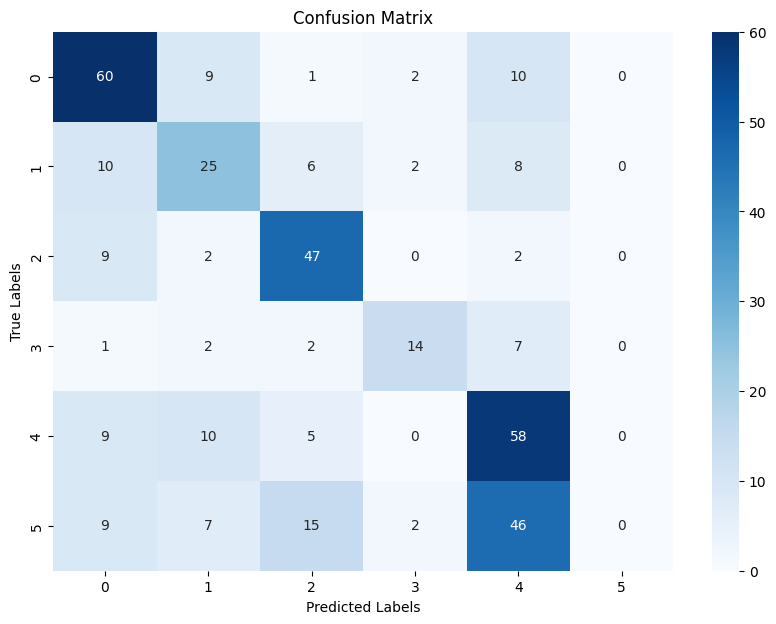

In [6]:
# Function to evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    total_test = 0
    correct_test = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (preds == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = correct_test / total_test * 100
    print(f'Test Accuracy: {accuracy:.2f}%')

    # Compute and plot the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Call the evaluation function to test the model
evaluate_model(model, test_loader)
